In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
rc('pdf', fonttype=42)

In [2]:
def contingency_table(df_review, columns=[]):
    tab = pd.crosstab(df_review['model_attr'], df_review['user_attr'], margins=True)
    if len(columns)>0:
        tab = tab[columns]
    print('contingency table')
    display(tab)
    tab = df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack()
    if len(columns)>1:
        tab = tab[columns[:-1]]
    g, p, dof, expctd = chi2_contingency(tab.values)
    print('chi2', g.round(3), 'p-value', p.round(3))
    print('')
    print('real market size - expcted market size')
    display((tab-expctd).round(2))
    

In [3]:
def chi2_test_by_year(df_review):
    chi, p, _, expctd = chi2_contingency(df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi1, p1, _, expctd1 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year<=2014)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi2, p2, _, expctd2 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year==2015)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi3, p3, _, expctd3 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year==2016)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi4, p4, _, expctd4 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year>=2017)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    df = pd.DataFrame(np.array([[chi, p, expctd.sum()],
                                [chi1, p1, expctd1.sum()],
                                [chi2, p2, expctd2.sum()],
                                [chi3, p3, expctd3.sum()],
                                [chi4, p4, expctd4.sum()],]), 
                      columns=['chi2', 'p-value', 'sum'],
                      index=['all', '<=2014', '2015', '2016', '>=2017'])
    display(df.round(3))

In [24]:
import csv
#from io import open
def load_data():
    data = []

    label = ['image_id','unixtime','rawtime','title','total_votes','reddit_id','number_of_upvotes',\
    'subreddit','number_of_downvotes','localtime','score','number_of_comments','username',\
    'undefined1','undefined2', 'undefined3']

    with open('submissions.csv') as csvfile:
        csvReader = csv.reader(csvfile)
        for row in csvReader:
            if row[0] == '#image_id':
                continue
            d = {}
            for i,elem in enumerate(row):
                d[label[i]] = elem
            data.append(d)

    return data


In [28]:
final_dataset = load_data()
final_dataset = pd.DataFrame(final_dataset)
# a= final_dataset1['number_of_comments']
# a.mean(axis = 0)
# print(a.mean())

In [31]:
from collections import defaultdict
import datetime
def convertNumToDay(num):
 weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
 return weekdays[num-1]
def convertHourToTime(num):
    if num == 0:
        timeOfDay = '12 AM'
    elif num <= 11:
        timeOfDay = str(num) + ' AM'
    elif num == 12:
        timeOfDay = '12 PM'
    else: 
        timeOfDay = str(num-12) + ' PM'
    return timeOfDay
r_score = defaultdict(list)
r_comm = defaultdict(list)
r_posts = {}
r_votes = defaultdict(list)
r_dayofweek = {}
r_hour = {}
length=-1
for index,i in final_dataset.iterrows():
  a = final_dataset["rawtime"]
  r_score[len(i["title"])].append(int(i['score']))
  r_comm[len(i["title"])].append(int(i['number_of_comments']))
  r_votes[len(i["title"])].append(int(i['total_votes']))
  a = (i['rawtime'])
  today = datetime.datetime(int(a[:4]), int(a[5:7]), int(a[8:10]),int(a[11:13]),int(a[14:16]),int(a[17:19]))
  r_dayofweek[len(i["title"])] = convertNumToDay(today.weekday())
  r_hour[len(i["title"])] = convertHourToTime(int(a[11:13]))
  r_votes[len(i["title"])].append(int(i['total_votes']))


  if   len(i["title"]) in r_posts.keys():  
      r_posts[len(i["title"])] += 1  
  else:  
      r_posts[len(i["title"])] = 1  


r_score_f = {}
for i in r_posts.keys():
   r_score_f[i] = sum(r_score[i])/len(r_score[i])
r_votes_f = {}
for i in r_votes.keys():
   r_votes_f[i] = sum(r_votes[i])/len(r_votes[i])
r_comm_f = {}
for i in r_comm.keys():
   r_comm_f[i] = sum(r_comm[i])/len(r_comm[i])


In [38]:
r_comm_f
a = [r_score_f,r_comm_f,r_posts,r_votes_f]
X= pd.DataFrame(a)
X= X.T
print(X)
print(X.columns)
#df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}) 
data = X.rename(columns ={0:"avg_score",1:"avg_comments",2:"num_posts","index":"length_title",3:"Total_votes"})
# data
# data.corr()
a = data.reset_index(inplace=True)
data.corr()


               0           1       2            3
22    238.323219   39.236478  3032.0  2123.004617
11    218.449559   31.963176  2607.0  1811.478328
8     236.151111   33.018413  1575.0  1934.580317
31    245.438407   36.224803  2411.0  2027.554542
30    226.752849   38.083694  2545.0  1845.878978
..           ...         ...     ...          ...
242    16.000000    6.000000     1.0    30.000000
222   730.500000  233.000000     2.0  2822.500000
267  1184.000000  119.000000     1.0  9798.000000
282   244.000000   43.000000     1.0   814.000000
239    12.000000    3.000000     1.0    22.000000

[260 rows x 4 columns]
RangeIndex(start=0, stop=4, step=1)


,index,avg_score,avg_comments,num_posts,Total_votes
index,1.000000,0.067306,0.073565,-0.699629,-0.035421
avg_score,0.067306,1.000000,0.560564,-0.044528,0.780559
avg_comments,0.073565,0.560564,1.000000,-0.080527,0.493923
num_posts,-0.699629,-0.044528,-0.080527,1.000000,-0.002560
Total_votes,-0.035421,0.780559,0.493923,-0.002560,1.000000


In [73]:
r_comm_f
a = [r_score_f,r_dayofweek,r_hour]
X1= pd.DataFrame(a)
X1= X1.T
# print(X1)
# print(X1.columns)
#df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}) 
# data = X.rename(columns ={1:"hourofday",0:"dayofweek",2:"num_posts","index":"length_title",3:"Total_votes"})

X1 = X1.reset_index()
data = X1.rename(columns ={0:"avg_score",1:"dayofweek",2:"hourofday",3:"num_posts","index":"length_title","index":"avg_length"})
data = data[1:4]
print(data)

# data.corr()
# a = data.reset_index(inplace=True)
# data.corr()
timeScoreMatrix = data.pivot(index='dayofweek', columns='hourofday', values='avg_score')
cols = data.columns.tolist()
print(cols)
print(cols)
print(cols)
# cols.insert(0, cols.pop(cols.index(22)))
fixedTimeScoreMatrix = data.reindex(columns="dayofweek")
data

   avg_length   avg_score dayofweek hourofday
1          11  218.449559    Friday      4 AM
2           8  236.151111  Thursday      3 PM
3          31  245.438407   Tuesday      8 PM
['avg_length', 'avg_score', 'dayofweek', 'hourofday']
['avg_length', 'avg_score', 'dayofweek', 'hourofday']
['avg_length', 'avg_score', 'dayofweek', 'hourofday']


TypeError: ignored

In [ ]:
##heat mapp ppp
timeScoreMatrix = timeScore.pivot(index='dayofweek', columns='hourofday', values='avg_score')
cols = timeScoreMatrix.columns.tolist()
cols.insert(0, cols.pop(cols.index(23)))
fixedTimeScoreMatrix = timeScoreMatrix.reindex(columns=cols)
timeScoreMatrix
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
fig = plt.figure()
fig, ax = plt.subplots(1,1,figsize=(15,15))
heatmap = ax.imshow(fixedTimeScoreMatrix, cmap='BuPu')
ax.set_xticklabels(np.append('', formattedTimeScore.hourofday.unique())) # columns
ax.set_yticklabels(np.append('', formattedTimeScore.dayofweek.unique())) # index


tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_title("Time of Day Posted vs Average Score")
ax.set_xlabel('Time of Day Posted (EST)')
ax.set_ylabel('Day of Week Posted')


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "3%", pad="1%")
fig.colorbar(heatmap, cax=cax)
plt.show()

NameError: ignored

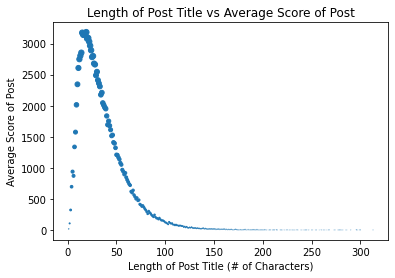

In [ ]:
X = data['index']
Y = data['num_posts']
Size = data['num_posts']/100
plt.scatter(x = X, y = Y, s = Size)
plt.title('Length of Post Title vs Average Score of Post')
plt.xlabel('Length of Post Title (# of Characters)')
plt.ylabel('Average Score of Post')
plt.show()

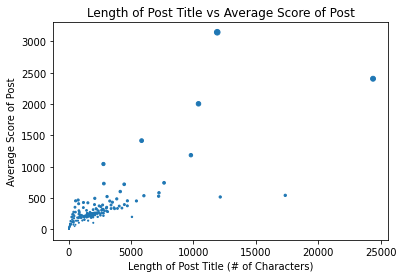

In [ ]:
X = data['Total_votes']
Y = data['avg_score']
Size = data['avg_score']/100
plt.scatter(x = X, y = Y, s = Size)
plt.title('Length of Post Title vs Average Score of Post')
plt.xlabel('Length of Post Title (# of Characters)')
plt.ylabel('Average Score of Post')
plt.show()

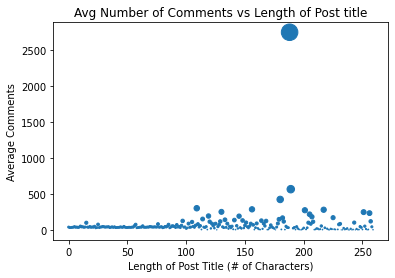

In [ ]:
X = data.index
Y = data['avg_comments']
Size = data['avg_comments']/10
plot = plt.scatter(x = X, y = Y, s = Size)
plt.title('Avg Number of Comments vs Length of Post title')
plt.xlabel('Length of Post Title (# of Characters)')
plt.ylabel('Average Comments')
plt.show()

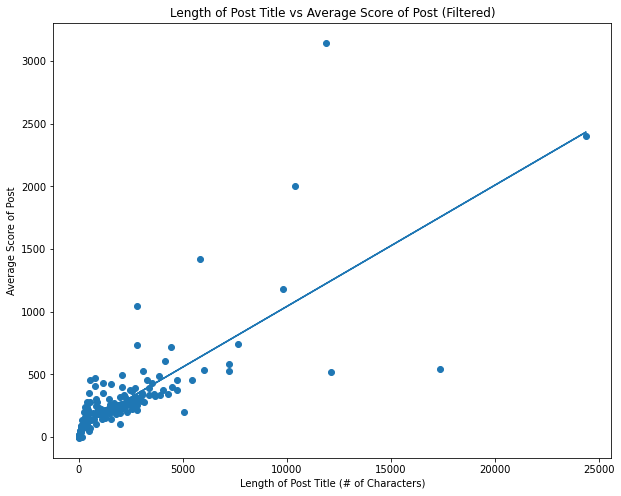

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
Y = data['avg_score']
X = data['Total_votes']

linear_regression = LinearRegression()
reshapedX = X.values.reshape(-1, 1)
linear_regression.fit(reshapedX, Y)
model = linear_regression.predict(reshapedX)

plt.figure(figsize=(10,8));
plt.scatter(X, Y);
plt.plot(X, model);
plt.title('Length of Post Title vs Average Score of Post (Filtered)')
plt.xlabel('Length of Post Title (# of Characters)')
plt.ylabel('Average Score of Post')
plt.show()

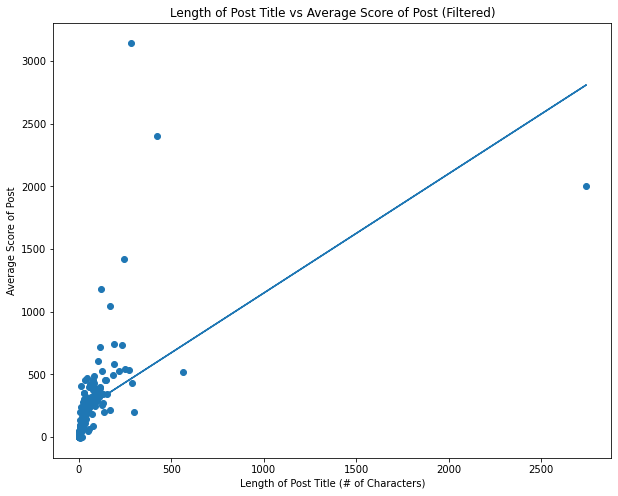

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
Y = data['avg_score']
X = data['avg_comments']

linear_regression = LinearRegression()
reshapedX = X.values.reshape(-1, 1)
linear_regression.fit(reshapedX, Y)
model = linear_regression.predict(reshapedX)

plt.figure(figsize=(10,8));
plt.scatter(X, Y);
plt.plot(X, model);
plt.title('Length of Post Title vs Average Score of Post (Filtered)')
plt.xlabel('Length of Post Title (# of Characters)')
plt.ylabel('Average Score of Post')
plt.show()

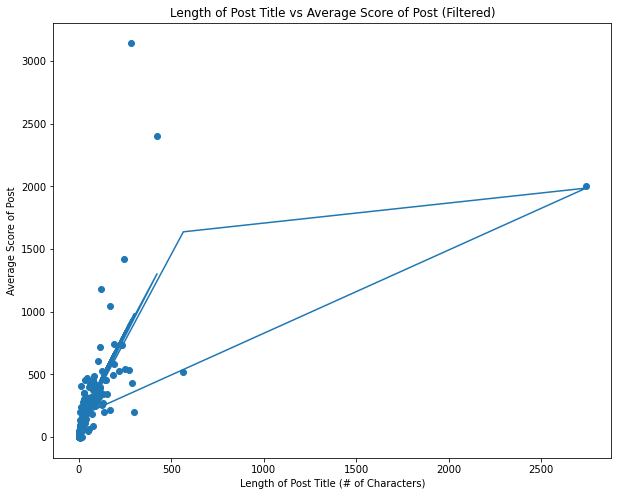

In [ ]:
import matplotlib.pyplot as plt

poly_reg = PolynomialFeatures(degree=2)
reshapedX = X.values.reshape(-1, 1)
poly = poly_reg.fit_transform(reshapedX)


linear_regression2 = LinearRegression()
reshapedY = Y.values.reshape(-1, 1)
linear_regression2.fit(poly, reshapedY)
y_pred = linear_regression2.predict(poly)
plt.figure(figsize=(10,8));
plt.scatter(X, Y);
plt.plot(X, y_pred);
plt.title('Length of Post Title vs Average Score of Post (Filtered)')
plt.xlabel('Length of Post Title (# of Characters)')
plt.ylabel('Average Score of Post')
plt.show()


In [ ]:
print

In [ ]:
Image_votes_total = final_dataset[['image_id','total_votes','score','username']]
from collections import defaultdict

user_votes = defaultdict(list)

for index,i in Image_votes_total.iterrows():
  a =[] 
  i['total_votes'] = int(i['total_votes'])
  user_votes[i['image_id']].append(i['total_votes'])
user_votes_f = {}
for i in user_votes.keys():
   user_votes_f[i] = sum(user_votes[i])/len(user_votes[i])

user_scores = defaultdict(list)

for index,i in Image_votes_total.iterrows():
  a =[] 
  i['score'] = int(i['score'])
  user_scores[i['image_id']].append(i['score'])
user_scores_f= {}
for i in user_scores_f.keys():
   user_scores_f[i] = sum(user_scores_f[i])/len(user_scores_f[i])

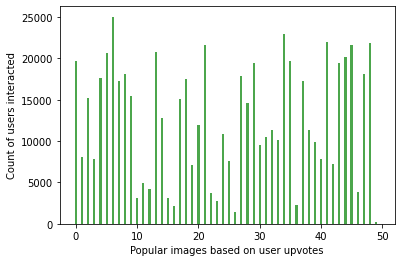

In [ ]:
sorted_dict = {}
sorted_keys = sorted(user_votes_f, key=user_votes_f.get,reverse=True)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = user_votes_f[w]
top_50_images = [int(v) for v in sorted_dict.keys()]
top_50_images = top_50_images[:50]
i_s = {}
for g in top_50_images:
  a=[]
  for index,i in Image_votes_total.iterrows():
    if(int(i['image_id']) == g):
      a.append(i['username'])
  i_s[g]=len(a)
a = i_s.values()
b = i_s.keys()
import matplotlib.pyplot as plt

# Some properties for the plot
alpha = 0.7
bar_width = 0.35
# LAbels for the both axis
plt.xlabel("Popular images based on user interactions")
plt.ylabel('User interactions')
# bar-plot
bar1 = plt.bar(np.arange(len(a)) + bar_width, a, bar_width, align='center', color='b', label='a-List')
bar2 = plt.bar(range(len(b)), b, bar_width, align='center', alpha=alpha, color='g', label='b-List')



#######################################
sorted_dict = {}
sorted_keys = sorted(user_scores_f, key=user_scores_f.get,reverse=True)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = user_scores_f[w]
top_50_images = [int(v) for v in sorted_dict.keys()]
top_50_images = top_50_images[:50]
i_s = {}
for g in top_50_images:
  a=[]
  for index,i in Image_votes_total.iterrows():
    if(int(i['image_id']) == g):
      a.append(i['username'])
  i_s[g]=len(a)
# Some properties for the plot
import matplotlib.pyplot as plt

a = i_s.values()
b = i_s.keys()
alpha = 0.7
bar_width = 0.35
# LAbels for the both axis
plt.xlabel("Popular images based on user upvotes")
plt.ylabel('Count of users interacted')
# bar-plot
bar1 = plt.bar(np.arange(len(a)) + bar_width, a, bar_width, align='center', color='b', label='a-List')
bar2 = plt.bar(range(len(b)), b, bar_width, align='center', alpha=alpha, color='g', label='b-List')


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Group A','Group B','Group C','Group D']
Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Girls')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Boys')
  
plt.xlabel("Groups")
plt.ylabel("Number of Students")
plt.title("Number of Students in each group")
plt.legend()
plt.show()

In [ ]:
chi = {}
for h in top_50_images:
  for index,i in final_dataset.iterrows():
    if(h== i["image_id"]):
        print(i["user_name"])
        chi[h].append(i["user_name"])

KeyboardInterrupt: ignored

In [ ]:
plot(x,y)

In [ ]:
is_count = {}
for i in i_s.keys():
   is_count[i] = sum(iv[i])/len(iv[i])

In [ ]:
print(is_count)

{}


In [ ]:
#caries to the sugars
# print(final_dataset['image_id'])
a =['number_of_comments', 'number_of_downvotes', 'number_of_upvotes']
final_dataset1 = final_dataset1[a]
# print(df_data_c)
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(font_scale=1.2)
# df_corr = df_data_c.corr()
# print(df_corr)
# print(df_corr)
# print(df_corr)
# print(df_corr)
# print(df_corr)
# ax = sns.heatmap(df_corr, annot=True, fmt=".3f",cmap="YlGnBu")
# plt.xticks(rotation = 70)
print(final_dataset1.corr())

Empty DataFrame
Columns: []
Index: []


In [ ]:
x= df_data_c[['number_of_comments',"number_of_downvotes"]]
dataset = 'modcloth'
df_review = pd.DataFrame()  
# df_review = pd.read_csv('/content/submissions.csv')
df_review['timestamp'] = (df_data_c['number_of_comments'])
df_review['fit_score'] = (df_data_c['number_of_downvotes'])
# df_review['fit_score'].loc[df_review['fit'] == 'Just right'] = 1.0
# df_review['fit_score'].loc[df_review['fit'].isna()] = None
# df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])
df_review.corr()
df_review.corr(method ='pearson')
df_review.head()
print(df_review.corr())

Empty DataFrame
Columns: []
Index: []
